In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve

import joblib
import xgboost as xgb
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

In [60]:
data = pd.read_csv("student_depression_dataset.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [61]:
def detailed_missing_breakdown(df):
    results = {
        'NaN': {},
        "'?'": {},
        'Whitespace': {}
    }

    for col in df.columns:
        stripped_col = df[col].astype(str).str.strip()

        results['NaN'][col] = df[col].isna().sum()
        results["'?'"][col] = (stripped_col == '?').sum()
        results['Whitespace'][col] = (stripped_col == '').sum()
    return pd.DataFrame(results)

detailed_missing_breakdown(data)

,NaN,'?',Whitespace
id,0,0,0
Gender,0,0,0
Age,0,0,0
City,0,0,0
Profession,0,0,0
Academic Pressure,0,0,0
Work Pressure,0,0,0
CGPA,0,0,0
Study Satisfaction,0,0,0
Job Satisfaction,0,0,0


In [62]:
data = data[data['Financial Stress'].astype(str).str.strip() != '?']
data['Financial Stress'] = data['Financial Stress'].astype(float)
data = data.drop('id', axis=1)

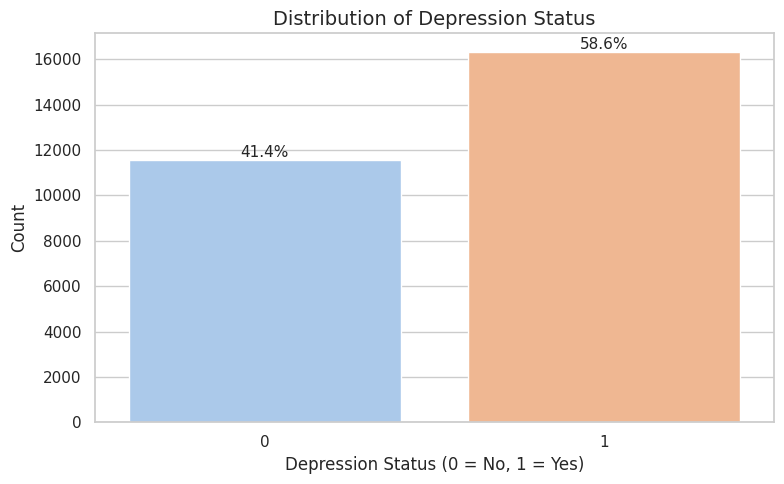

In [63]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Depression', data=data, palette='pastel')
plt.title('Distribution of Depression Status', fontsize=14)
plt.xlabel('Depression Status (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

total = len(data)
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = count
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()


Categorical Columns: ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Analysis for: Gender
Unique values: ['Male' 'Female']
Value counts:
Gender
Male      15546
Female    12352
Name: count, dtype: int64


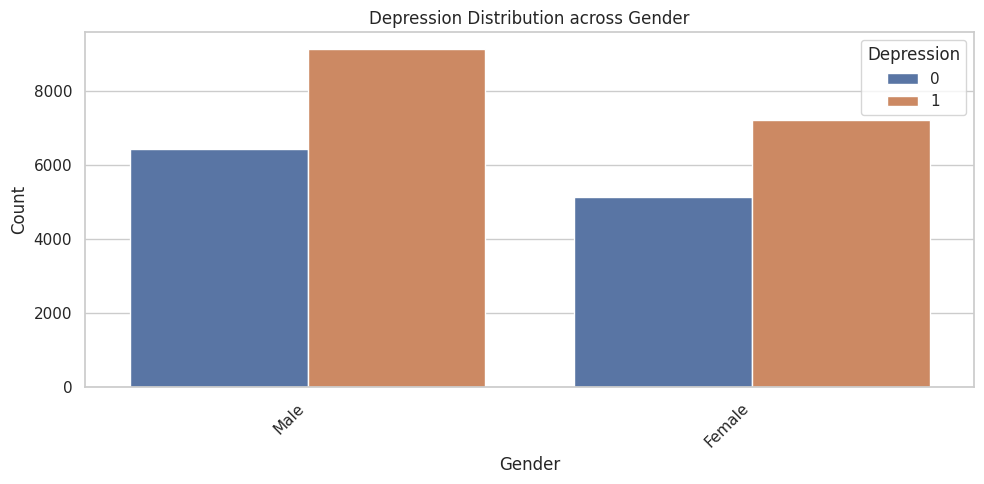


Analysis for: City
Unique values: ['Visakhapatnam' 'Bangalore' 'Srinagar' 'Varanasi' 'Jaipur' 'Pune' 'Thane'
 'Chennai' 'Nagpur' 'Nashik' 'Vadodara' 'Kalyan' 'Rajkot' 'Ahmedabad'
 'Kolkata' 'Mumbai' 'Lucknow' 'Indore' 'Surat' 'Ludhiana' 'Bhopal'
 'Meerut' 'Agra' 'Ghaziabad' 'Hyderabad' 'Vasai-Virar' 'Kanpur' 'Patna'
 'Faridabad' 'Delhi' 'Saanvi' 'M.Tech' 'Bhavna' "'Less Delhi'" 'City'
 '3.0' "'Less than 5 Kalyan'" 'Mira' 'Harsha' 'Vaanya' 'Gaurav' 'Harsh'
 'Reyansh' 'Kibara' 'Rashi' 'ME' 'M.Com' 'Nalyan' 'Mihir' 'Nalini'
 'Nandini' 'Khaziabad']
Value counts:
City
Kalyan                  1570
Srinagar                1372
Hyderabad               1339
Vasai-Virar             1290
Lucknow                 1155
Thane                   1139
Ludhiana                1111
Agra                    1094
Surat                   1078
Kolkata                 1065
Jaipur                  1036
Patna                   1007
Visakhapatnam            969
Pune                     968
Ahmedabad              

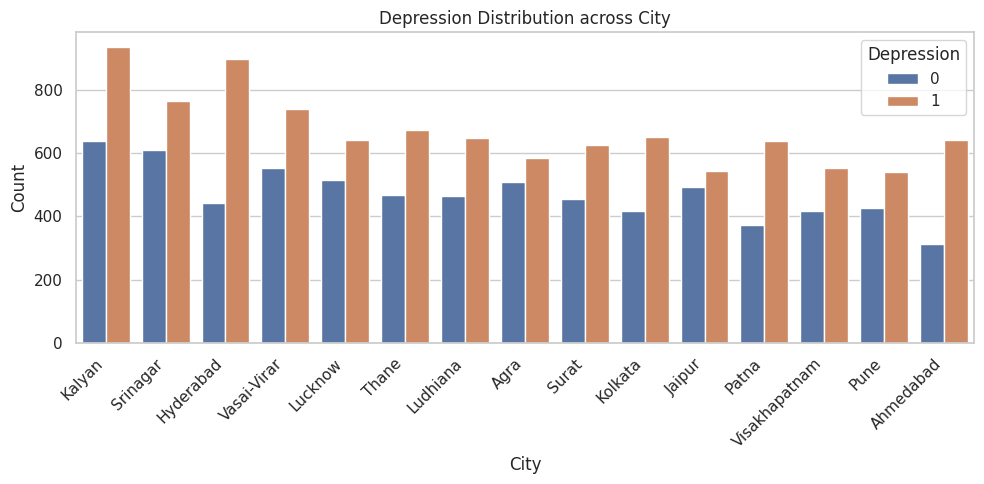


Analysis for: Profession
Unique values: ['Student' "'Civil Engineer'" 'Architect' "'UX/UI Designer'"
 "'Digital Marketer'" "'Content Writer'" "'Educational Consultant'"
 'Teacher' 'Manager' 'Chef' 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']
Value counts:
Profession
Student                     27867
Architect                       8
Teacher                         6
'Digital Marketer'              3
Chef                            2
'Content Writer'                2
Pharmacist                      2
Doctor                          2
'UX/UI Designer'                1
'Civil Engineer'                1
Manager                         1
'Educational Consultant'        1
Lawyer                          1
Entrepreneur                    1
Name: count, dtype: int64


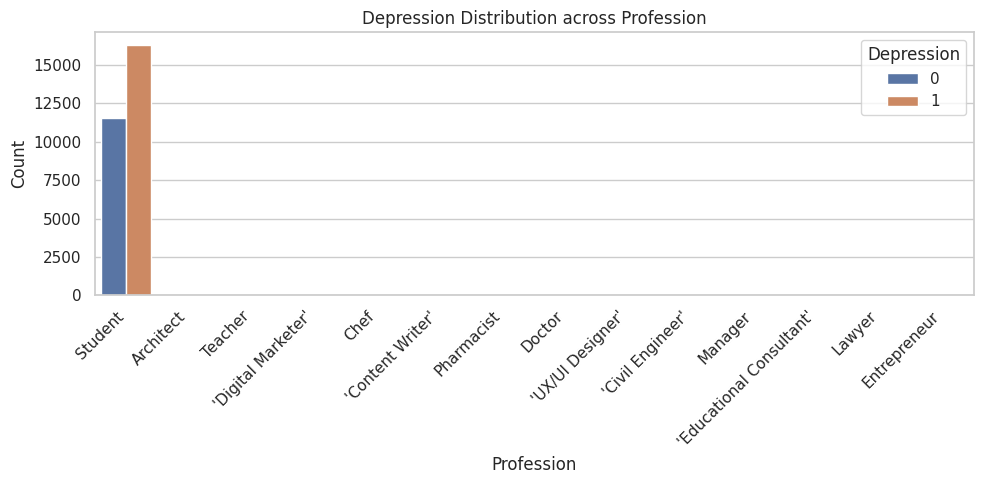


Analysis for: Sleep Duration
Unique values: ["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
Value counts:
Sleep Duration
'Less than 5 hours'    8309
'7-8 hours'            7346
'5-6 hours'            6181
'More than 8 hours'    6044
Others                   18
Name: count, dtype: int64


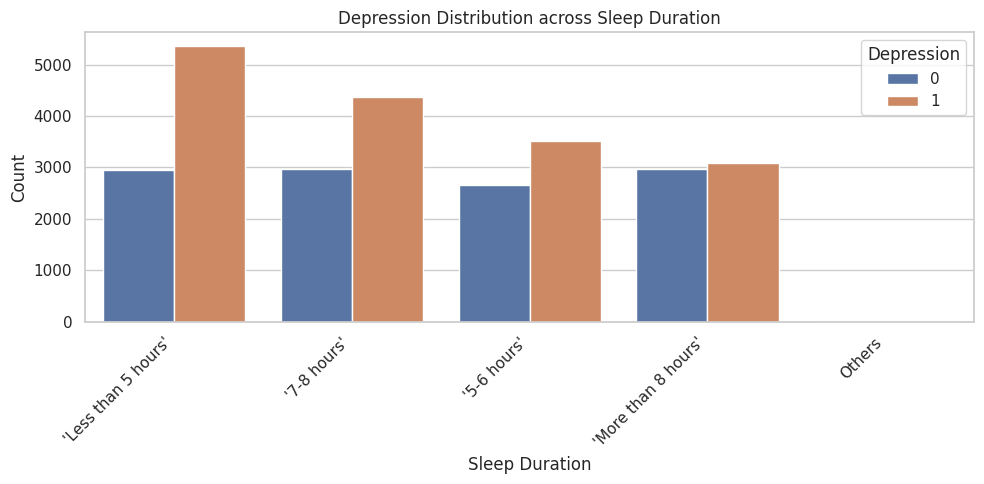


Analysis for: Dietary Habits
Unique values: ['Healthy' 'Moderate' 'Unhealthy' 'Others']
Value counts:
Dietary Habits
Unhealthy    10316
Moderate      9921
Healthy       7649
Others          12
Name: count, dtype: int64


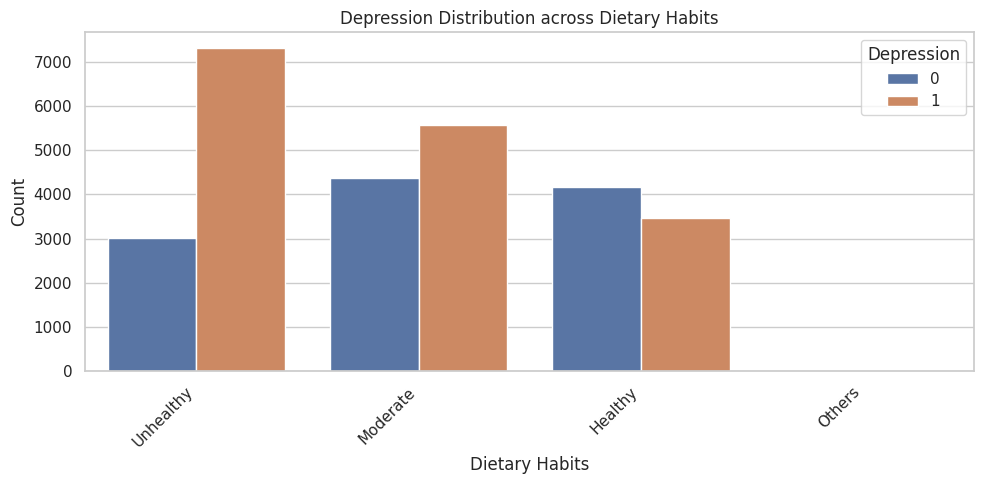


Analysis for: Degree
Unique values: ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' "'Class 12'" 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']
Value counts:
Degree
'Class 12'    6080
B.Ed          1866
B.Com         1506
B.Arch        1478
BCA           1432
MSc           1190
B.Tech        1152
MCA           1044
M.Tech        1022
BHM            925
BSc            888
M.Ed           821
B.Pharm        810
M.Com          734
BBA            696
MBBS           695
LLB            671
BE             613
BA             600
M.Pharm        582
MD             572
MBA            562
MA             544
PhD            522
LLM            482
MHM            191
ME             185
Others          35
Name: count, dtype: int64


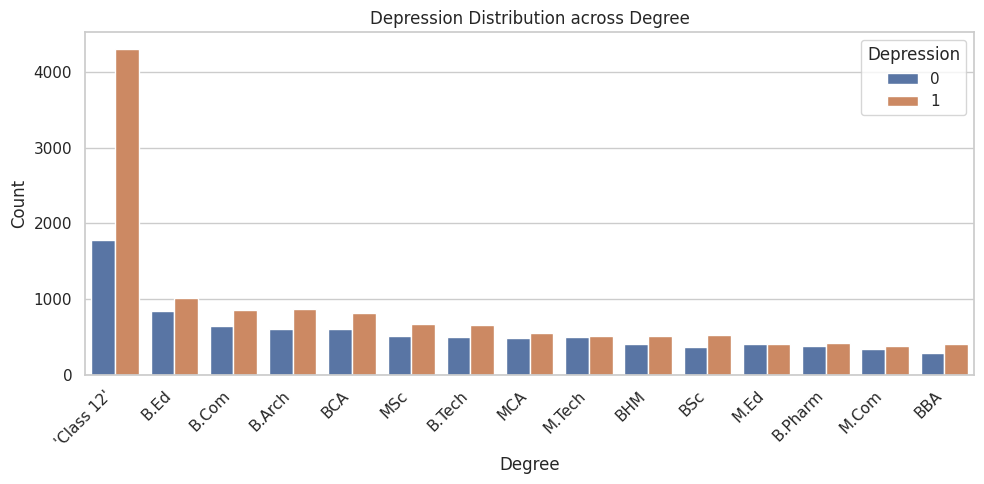


Analysis for: Have you ever had suicidal thoughts ?
Unique values: ['Yes' 'No']
Value counts:
Have you ever had suicidal thoughts ?
Yes    17656
No     10242
Name: count, dtype: int64


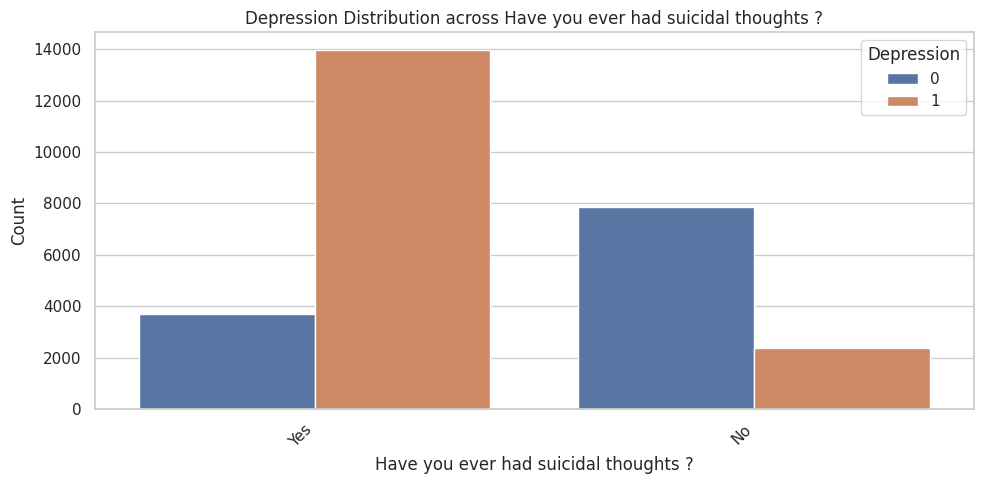


Analysis for: Family History of Mental Illness
Unique values: ['No' 'Yes']
Value counts:
Family History of Mental Illness
No     14397
Yes    13501
Name: count, dtype: int64


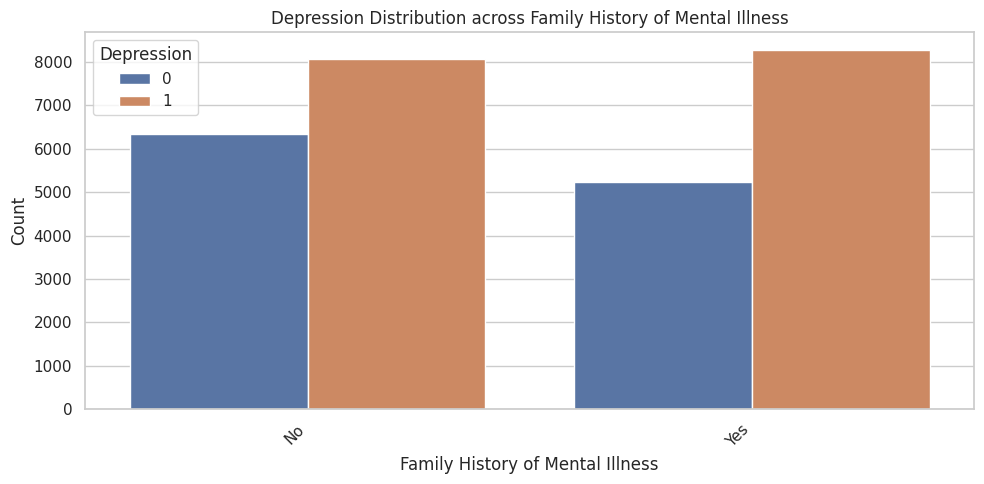

In [64]:
categorical_cols = data.select_dtypes(include='object').columns
print(f"\nCategorical Columns: {list(categorical_cols)}")

for col in categorical_cols:
    print(f"\nAnalysis for: {col}")
    print(f"Unique values: {data[col].unique()}")
    print(f"Value counts:\n{data[col].value_counts()}")

    #relationship with depression
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=data, hue='Depression', order = data[col].value_counts().index[:15])
    plt.title(f'Depression Distribution across {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [65]:
def extract_hours(s):
    # Find a number (including decimals)
    match = re.search(r"(\d+(\.\d+)?)", str(s))
    return float(match.group(1)) if match else np.nan

data['Sleep Duration'] = data['Sleep Duration'].apply(extract_hours)
for col in ['Sleep Duration']:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

In [66]:
binary_map = {'Yes': 1, 'No': 0}
data['Suicidal Thoughts Binary'] = data['Have you ever had suicidal thoughts ?'].map(binary_map)
data['Family History Binary'] = data['Family History of Mental Illness'].map(binary_map)

data = data.drop(['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], axis=1)
data.head()

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Work/Study Hours,Financial Stress,Depression,Suicidal Thoughts Binary,Family History Binary
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5.0,Healthy,B.Pharm,3.0,1.0,1,1,0
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5.0,Moderate,BSc,3.0,2.0,0,0,1
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,5.0,Healthy,BA,9.0,1.0,0,0,1
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7.0,Moderate,BCA,4.0,5.0,1,1,1
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5.0,Moderate,M.Tech,1.0,1.0,0,1,0


In [67]:
# Remove columns deemed unsuitable for the model
# 'City' (high cardinality/noise) and 'Profession' (low variance)
columns_to_drop = ['City', 'Profession']
print(f"\nDropping columns: {columns_to_drop}")
data = data.drop(columns=columns_to_drop, errors='ignore')


Dropping columns: ['City', 'Profession']


In [68]:
# Remove rows with the vague and infrequent 'Others' category in 'Dietary Habits'.
original_rows = data.shape[0]
data = data[data['Dietary Habits'] != 'Others']
rows_after_diet_filter = data.shape[0]
print(f"Removed {original_rows - rows_after_diet_filter} rows.")
print(f"Unique values in 'Dietary Habits' now: {data['Dietary Habits'].unique()}")

Removed 12 rows.
Unique values in 'Dietary Habits' now: ['Healthy' 'Moderate' 'Unhealthy']


In [69]:
# Clean the 'Degree' column and remove the vague 'Others' category.
data['Degree'] = data['Degree'].astype(str).str.replace("'", "")
others_count = (data['Degree'] == 'Others').sum()
print(f"Count of 'Others' in cleaned 'Degree' column: {others_count}")

if others_count > 0:
    print(f"Filtering rows where cleaned 'Degree' is 'Others'...")
    original_rows = data.shape[0]
    data = data[data['Degree'] != 'Others']
    rows_after_degree_filter = data.shape[0]
    print(f"Removed {original_rows - rows_after_degree_filter} rows.")
    print(f"Unique values in 'Degree' now (sample): {data['Degree'].unique()[:15]}...")
else:
    print("No 'Others' found in cleaned 'Degree' column to filter.")

Count of 'Others' in cleaned 'Degree' column: 35
Filtering rows where cleaned 'Degree' is 'Others'...
Removed 35 rows.
Unique values in 'Degree' now (sample): ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA']...


In [70]:
categorical_cols_remaining = data.select_dtypes(include='object').columns
print(f"\nCategorical columns to encode: {list(categorical_cols_remaining)}")


Categorical columns to encode: ['Gender', 'Dietary Habits', 'Degree']


In [71]:
# Encode Remaining Categorical Features
categorical_cols_remaining = data.select_dtypes(include='object').columns
print(f"\nCategorical columns to encode: {list(categorical_cols_remaining)}")

if len(categorical_cols_remaining) > 0:
    print("Applying One-Hot Encoding")
    data_processed = pd.get_dummies(data, columns=categorical_cols_remaining, drop_first=True)
    print("One-Hot Encoding complete.")
    print(f"Shape after encoding: {data_processed.shape}")
    print(f"Sample of columns after encoding: {data_processed.columns[:5].tolist()} ... {data_processed.columns[-5:].tolist()}")
else:
    print("No remaining object columns to encode.")
    data_processed = data.copy()

print("\nData types after encoding:")
print(data_processed.info())


Categorical columns to encode: ['Gender', 'Dietary Habits', 'Degree']
Applying One-Hot Encoding
One-Hot Encoding complete.
Shape after encoding: (27851, 41)
Sample of columns after encoding: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction'] ... ['Degree_MD', 'Degree_ME', 'Degree_MHM', 'Degree_MSc', 'Degree_PhD']

Data types after encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 27851 entries, 0 to 27900
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       27851 non-null  float64
 1   Academic Pressure         27851 non-null  float64
 2   Work Pressure             27851 non-null  float64
 3   CGPA                      27851 non-null  float64
 4   Study Satisfaction        27851 non-null  float64
 5   Job Satisfaction          27851 non-null  float64
 6   Sleep Duration            27851 non-null  float64
 7   Work/Study Hours          2

In [72]:
# Define Features (X) and Target (y)
X = data_processed.drop('Depression', axis=1)
y = data_processed['Depression']

In [73]:
data_processed.shape

(27851, 41)

In [74]:
# Split Data into Training and Testing Sets - (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Test set size: X_test {X_test.shape}, y_test {y_test.shape}")
# Check stratification
print(f"Depression proportion in Training set: {y_train.mean():.3f}")
print(f"Depression proportion in Test set: {y_test.mean():.3f}")

Training set size: X_train (19495, 40), y_train (19495,)
Test set size: X_test (8356, 40), y_test (8356,)
Depression proportion in Training set: 0.585
Depression proportion in Test set: 0.585


In [75]:
# Scale Numerical Features ---
print("\nScaling Numerical Features using StandardScaler")
# excluding binary features (like Suicidal Thoughts Binary, Family History Binary)
# excluding the new 0/1 features created by get_dummies.
cols_to_scale = [col for col in X_train.columns
                 if not X_train[col].isin([0, 1]).all()]

print(f"Columns identified for scaling ({len(cols_to_scale)}):")
print(cols_to_scale)

scaler = StandardScaler()

print("Fitting scaler on training data...")
scaler.fit(X_train[cols_to_scale])

print("Transforming training and test data...")
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
print("Ready for model training.")


Scaling Numerical Features using StandardScaler
Columns identified for scaling (9):
['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours', 'Financial Stress']
Fitting scaler on training data...
Transforming training and test data...
Ready for model training.


In [77]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Logistic Regression with Regularization
print("\n=== Logistic Regression with Cross-Validation ===")
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    log_reg_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
log_reg_grid.fit(X_train, y_train)
print(f"Best Logistic Regression parameters: {log_reg_grid.best_params_}")
log_reg = log_reg_grid.best_estimator_

# Evaluate with cross-validation
log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"CV ROC-AUC scores: {log_reg_cv_scores}")
print(f"Mean CV ROC-AUC: {log_reg_cv_scores.mean():.4f} ± {log_reg_cv_scores.std():.4f}")

# Test set evaluation
y_pred_log_reg = log_reg.predict(X_test)
y_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_log_reg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))

# ROC Curve data
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_proba_log_reg)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)


=== Logistic Regression with Cross-Validation ===
Best Logistic Regression parameters: {'C': 0.1, 'penalty': 'l1'}
CV ROC-AUC scores: [0.91879878 0.91953711 0.91608418 0.9216177  0.92129732]
Mean CV ROC-AUC: 0.9195 ± 0.0020

Test Set Evaluation:
Accuracy: 0.8504
ROC-AUC: 0.9244

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3464
           1       0.86      0.89      0.87      4892

    accuracy                           0.85      8356
   macro avg       0.85      0.84      0.84      8356
weighted avg       0.85      0.85      0.85      8356



In [78]:
# Random Forest with Hyperparameter Tuning
print("\n=== Random Forest with Hyperparameter Tuning ===")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
rf_clf = rf_grid.best_estimator_

# Evaluate with cross-validation
rf_cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"CV ROC-AUC scores: {rf_cv_scores}")
print(f"Mean CV ROC-AUC: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

# Test set evaluation
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC Curve data
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


=== Random Forest with Hyperparameter Tuning ===
Best Random Forest parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
CV ROC-AUC scores: [0.91405758 0.91401225 0.9118227  0.92031096 0.91640537]
Mean CV ROC-AUC: 0.9153 ± 0.0029

Test Set Evaluation:
Accuracy: 0.8451
ROC-AUC: 0.9207

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      3464
           1       0.85      0.89      0.87      4892

    accuracy                           0.85      8356
   macro avg       0.84      0.84      0.84      8356
weighted avg       0.84      0.85      0.84      8356



In [79]:
# XGBoost Classifier
print("\n=== XGBoost Classifier ===")
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_params,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
xgb_clf = xgb_grid.best_estimator_

# Evaluate with cross-validation
xgb_cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"CV ROC-AUC scores: {xgb_cv_scores}")
print(f"Mean CV ROC-AUC: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

# Test set evaluation
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve data
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


=== XGBoost Classifier ===
Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
CV ROC-AUC scores: [0.91838144 0.91904081 0.91571866 0.92131968 0.92191369]
Mean CV ROC-AUC: 0.9193 ± 0.0022

Test Set Evaluation:
Accuracy: 0.8490
ROC-AUC: 0.9248

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      3464
           1       0.86      0.89      0.87      4892

    accuracy                           0.85      8356
   macro avg       0.85      0.84      0.84      8356
weighted avg       0.85      0.85      0.85      8356



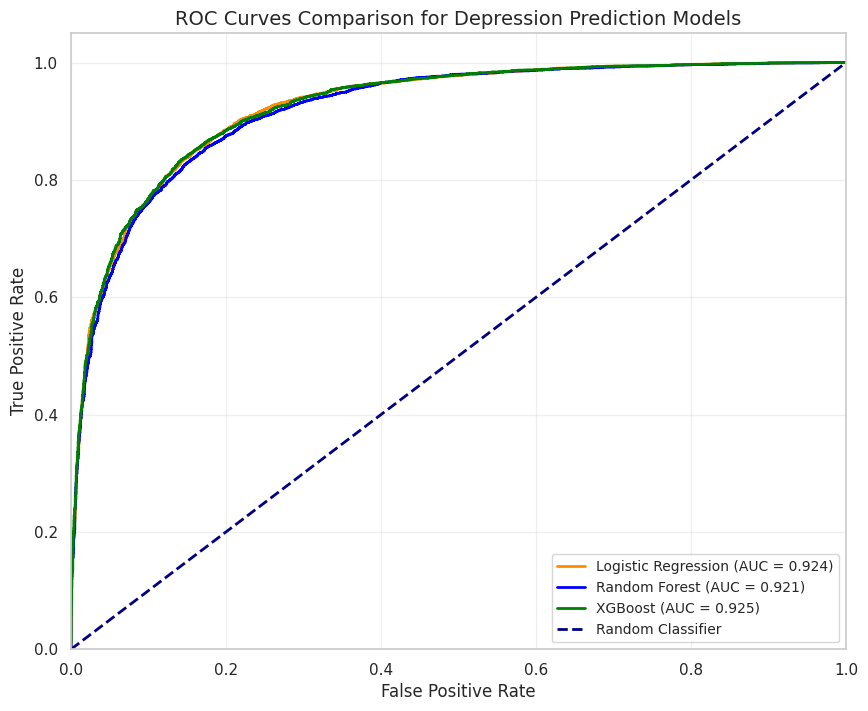

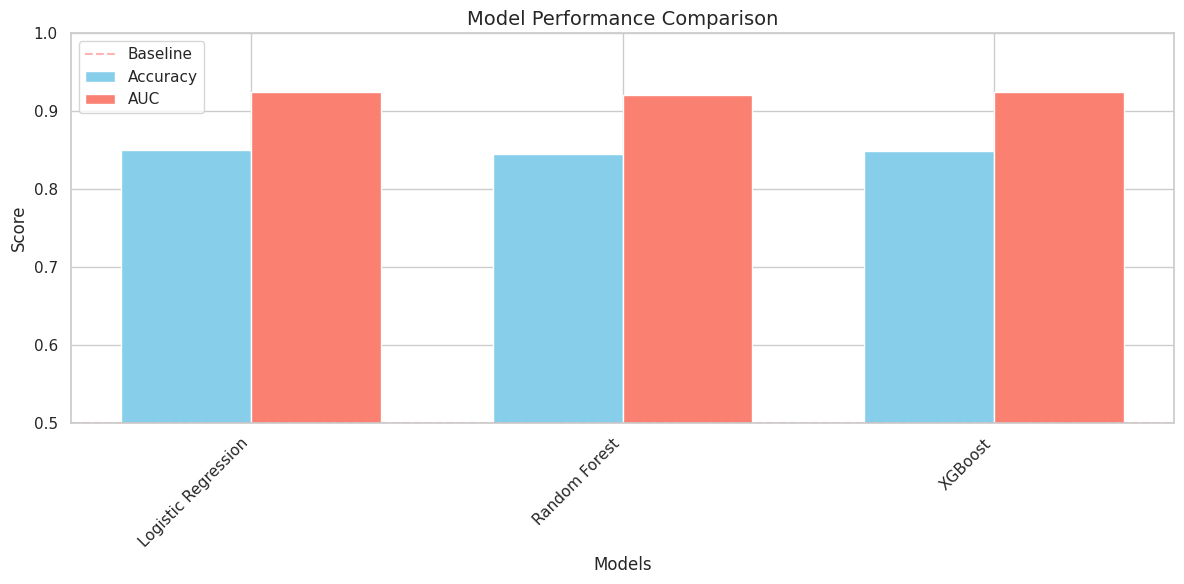

In [82]:
# Compare ROC curves of all models
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.3f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison for Depression Prediction Models', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare model performances with bar chart
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_log_reg),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb)
]
aucs = [roc_auc_log_reg, roc_auc_rf, roc_auc_xgb]

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, aucs, width, label='AUC', color='salmon')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Baseline')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

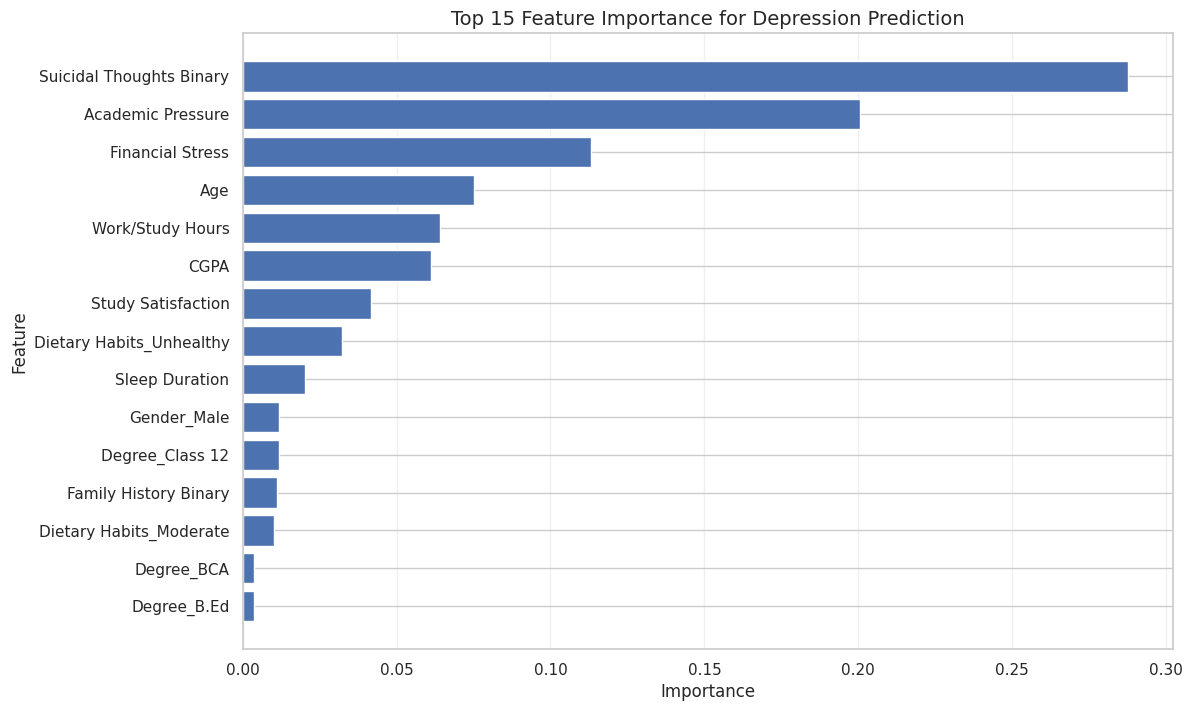

In [83]:
# Feature Importance Analysis from Random Forest
plt.figure(figsize=(12, 8))
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

top_n = 15
plt.barh(feature_importances['Feature'][:top_n], feature_importances['Importance'][:top_n])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance for Depression Prediction', fontsize=14)
plt.gca().invert_yaxis()  # Display most important at top
plt.grid(axis='x', alpha=0.3)
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

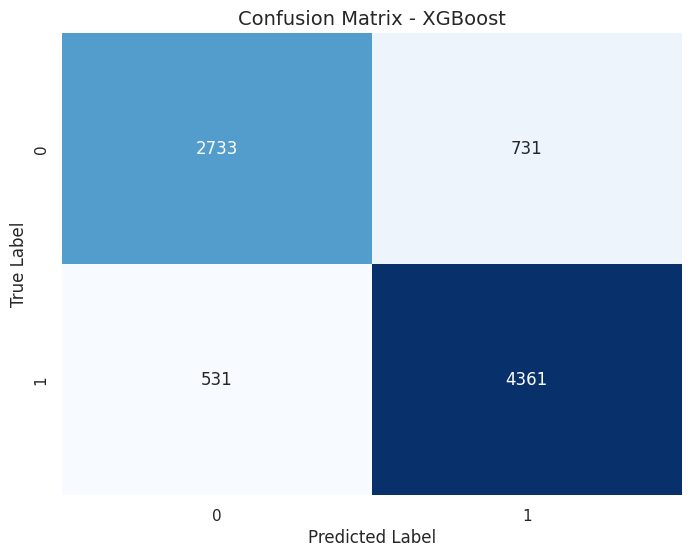

In [85]:
# Create a confusion matrix heatmap for the best model
models_dict = {
    'Logistic Regression': (y_test, y_pred_log_reg, roc_auc_log_reg),
    'Random Forest': (y_test, y_pred_rf, roc_auc_rf),
    'XGBoost': (y_test, y_pred_xgb, roc_auc_xgb)
}
best_model_name = max(models_dict.items(), key=lambda x: x[1][2])[0]
_, y_pred_best, _ = models_dict[best_model_name]

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

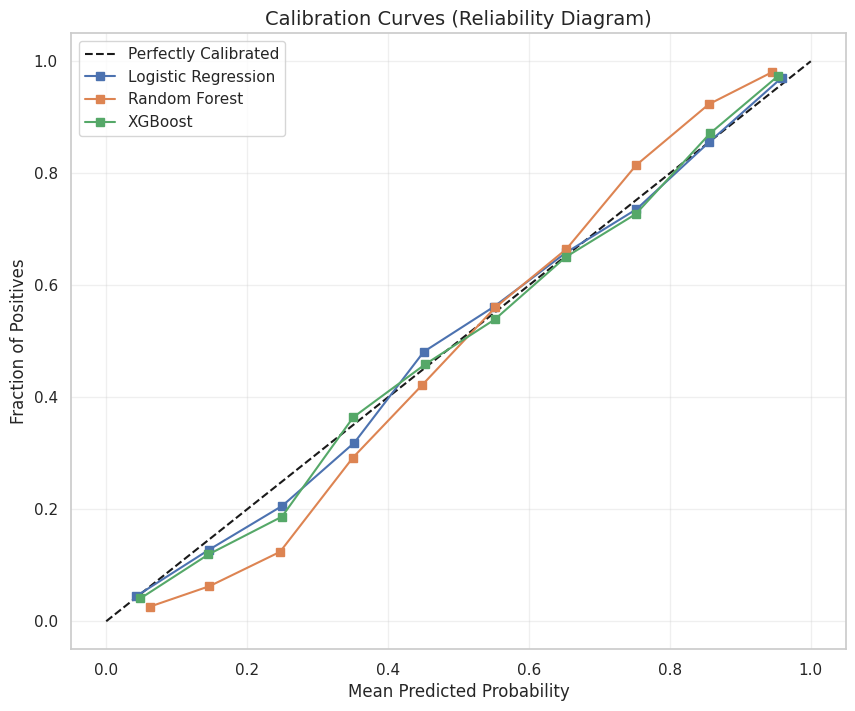

In [87]:
# Model Calibration Plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

# Calculate calibration curves
prob_true_log_reg, prob_pred_log_reg = calibration_curve(y_test, y_proba_log_reg, n_bins=10)
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_proba_rf, n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_proba_xgb, n_bins=10)

# Plot calibration curves
plt.plot(prob_pred_log_reg, prob_true_log_reg, 's-', label='Logistic Regression')
plt.plot(prob_pred_rf, prob_true_rf, 's-', label='Random Forest')
plt.plot(prob_pred_xgb, prob_true_xgb, 's-', label='XGBoost')

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curves (Reliability Diagram)', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.savefig('calibration_curves.png', dpi=300, bbox_inches='tight')
plt.show()


=== Model Stacking with Meta-Learner ===
Stacked Model Evaluation:
Accuracy: 0.8490
ROC-AUC: 0.9249

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3464
           1       0.86      0.89      0.87      4892

    accuracy                           0.85      8356
   macro avg       0.85      0.84      0.84      8356
weighted avg       0.85      0.85      0.85      8356



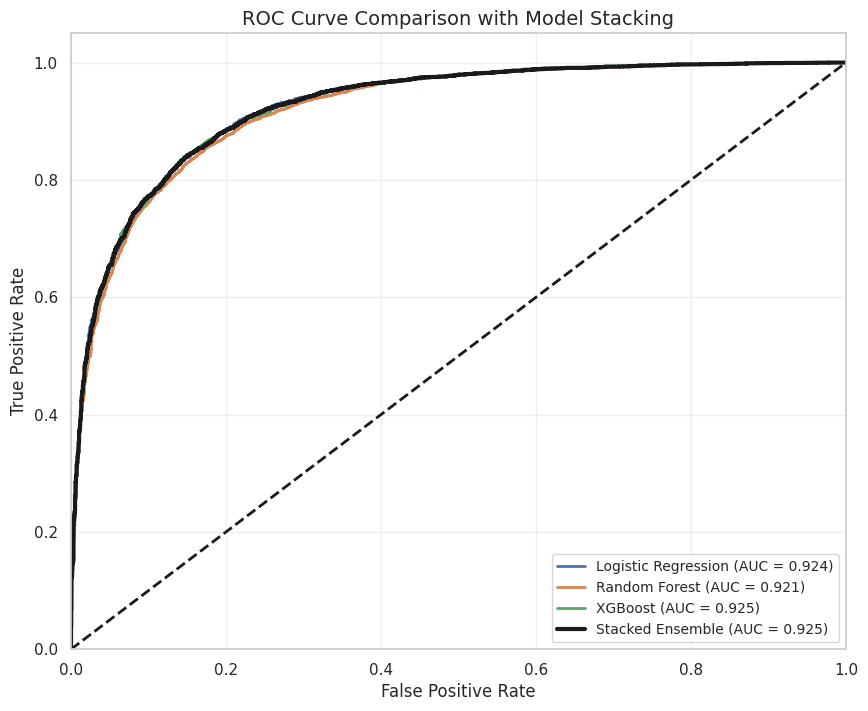

In [88]:
# Model Stacking with Meta-Learner
print("\n=== Model Stacking with Meta-Learner ===")
# Define base models
base_models = [
    ('lr', log_reg),
    ('rf', rf_clf),
    ('xgb', xgb_clf)
]

# Define meta-learner
meta_learner = LogisticRegression(random_state=42)

# Create stacked model
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba'
)

# Train and evaluate stacked model
stacked_model.fit(X_train, y_train)
y_pred_stacked = stacked_model.predict(X_test)
y_proba_stacked = stacked_model.predict_proba(X_test)[:, 1]

print("Stacked Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_stacked):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_stacked):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stacked))

# Add stacked model to ROC curve comparison
fpr_stacked, tpr_stacked, _ = roc_curve(y_test, y_proba_stacked)
roc_auc_stacked = auc(fpr_stacked, tpr_stacked)

plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, lw=2, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.3f})')
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot(fpr_stacked, tpr_stacked, 'k-', lw=3, label=f'Stacked Ensemble (AUC = {roc_auc_stacked:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison with Model Stacking', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('roc_curve_with_stacking.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
# Save the best performing model for future use
best_models = {
    'logistic_regression': log_reg,
    'random_forest': rf_clf,
    'xgboost': xgb_clf,
    'stacked_model': stacked_model
}

# Determine best model by AUC
aucs = {
    'logistic_regression': roc_auc_log_reg,
    'random_forest': roc_auc_rf,
    'xgboost': roc_auc_xgb,
    'stacked_model': roc_auc_stacked
}
best_model_key = max(aucs, key=aucs.get)
best_model = best_models[best_model_key]

# Save best model
joblib.dump(best_model, f'best_depression_model_{best_model_key}.pkl')
print(f"\nBest model ({best_model_key}) saved successfully!")

# Save scaling information
joblib.dump(scaler, 'feature_scaler.pkl')
print("Feature scaler saved successfully!")


Best model (stacked_model) saved successfully!
Feature scaler saved successfully!
